<a href="https://colab.research.google.com/github/hgene0929/deep_learning/blob/main/segmentation_test_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir /content/data

In [ ]:
!mkdir ./pretrained
!wget -O ./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_mask_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt
!tar -xvf ./pretrained/mask*.tar.gz -C ./pretrained 

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}



#masking 시 클래스별 컬러 적용
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250],
     [50, 190, 190]] )

In [9]:
def detect_image_mask_rcnn(cv_net, img_array, conf_threshold, mask_threshold, use_copied_array, fixed_classId):
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
    else:
        draw_img = img_array
    
    blob = cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False)
    cv_net.setInput(blob)
    boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])

    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    img_height = img_array.shape[0]
    img_width = img_array.shape[1]
    
    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > conf_threshold:
            classId = int(box[1])
            if classId == fixed_classId:
              left = int(img_width * box[3])
              top = int(img_height * box[4])
              right = int(img_width * box[5])
              bottom = int(img_height * box[6])

              #### Detect된 Object에 대한 image mask 처리 수행을 위한 기본 정보 추출. 
              # 네트웍 모델에서 반환된 detect된 object의 mask 정보 추출
              classMask = mask[classId]
              # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
              scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
              # 지정된 mask Threshold 값 이상인지 True, False boolean형태의 mask 정보 생성. 
              s_mask_b = (scaled_classMask > mask_threshold)
    
    return s_mask_b

In [45]:
def draw_segmentation(mask_array, img, is_background):

  draw_img = None
  if is_background == True:
    non_zero_indexes = np.where(mask_array > 0)
    draw_img = img.copy()
    draw_img[non_zero_indexes[0]+500, non_zero_indexes[1]+500, :] = 0

  else:
    zero_indexes = np.where(mask_array <= 0)
    draw_img = img.copy()
    draw_img[zero_indexes[0]+20, zero_indexes[1]+80, :] = 0

  return draw_img

In [22]:
import os
# image 로드 
img_bg = cv2.imread('./data/car_img1.jpg')
img_rgb_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_fg = cv2.imread('./data/car_img2.jpg')
img_rgb_fg = cv2.cvtColor(img_fg, cv2.COLOR_BGR2RGB)

cv_net_bg = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_mask_graph.pbtxt')
blob_bg = cv2.dnn.blobFromImage(img_bg , swapRB=True, crop=False)
cv_net_bg.setInput(blob_bg)

cv_net_fg = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_mask_graph.pbtxt')
blob_fg = cv2.dnn.blobFromImage(img_fg , swapRB=True, crop=False)
cv_net_fg.setInput(blob_fg)

In [23]:
mask_array_bg = img_detected_bg = detect_image_mask_rcnn(cv_net_bg, img_bg, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, fixed_classId=2)
mask_array_fg = img_detected_fg = detect_image_mask_rcnn(cv_net_fg, img_fg, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, fixed_classId=2)

In [24]:
draw_img_bg = draw_segmentation(mask_array_bg, img_bg, is_background=True)
draw_img_fg = draw_segmentation(mask_array_fg, img_fg, is_background=False)

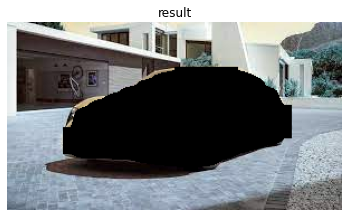

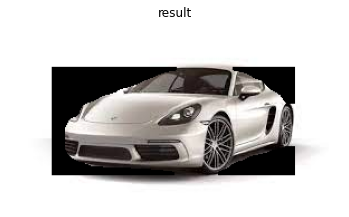

In [25]:
plt.figure(figsize=(6,6))
plt.title('result')
plt.axis('off')
plt.imshow(draw_img_bg)

plt.figure(figsize=(6,6))
plt.title('result')
plt.axis('off')
plt.imshow(draw_img_fg)

In [26]:
dst = cv2.add(draw_img_bg, draw_img_fg)

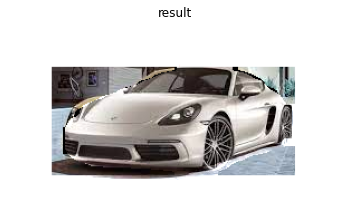

In [27]:
plt.figure(figsize=(6,6))
plt.title('result')
plt.axis('off')
plt.imshow(dst)

In [28]:
import os
# image 로드 
img_bg = cv2.imread('./data/image1.jpg')
img_rgb_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_fg = cv2.imread('./data/marcerati.jpg')
img_rgb_fg = cv2.cvtColor(img_fg, cv2.COLOR_BGR2RGB)

cv_net_bg = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_mask_graph.pbtxt')
blob_bg = cv2.dnn.blobFromImage(img_bg , swapRB=True, crop=False)
cv_net_bg.setInput(blob_bg)

cv_net_fg = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_mask_graph.pbtxt')
blob_fg = cv2.dnn.blobFromImage(img_fg , swapRB=True, crop=False)
cv_net_fg.setInput(blob_fg)

In [46]:
mask_array_bg = img_detected_bg = detect_image_mask_rcnn(cv_net_bg, img_bg, conf_threshold=0.1, mask_threshold=0.3, use_copied_array=True, fixed_classId=2)
mask_array_fg = img_detected_fg = detect_image_mask_rcnn(cv_net_fg, img_fg, conf_threshold=0.5, mask_threshold=0.3, use_copied_array=True, fixed_classId=2)

In [47]:
draw_img_bg = draw_segmentation(mask_array_bg, img_bg, is_background=True)
draw_img_fg = draw_segmentation(mask_array_fg, img_fg, is_background=False)

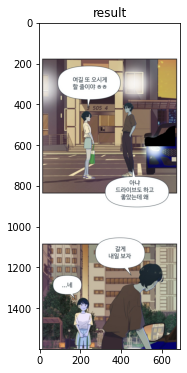

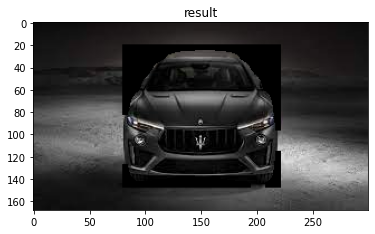

In [48]:
plt.figure(figsize=(6,6))
plt.title('result')
#plt.axis('off')
plt.imshow(draw_img_bg)

plt.figure(figsize=(6,6))
plt.title('result')
#plt.axis('off')
plt.imshow(draw_img_fg)